## Data Munging

In [1]:
import os
import pandas as pd
import numpy as np
import tqdm
# plotting
import graphviz
from matplotlib import pyplot as plt 
# now model fitting imports
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix

In [2]:
data_dir = 'MobiAct_v2/'
#types = ['BSC', 'CSI', 'CSO', 'FKL', 'FOL', 'JOG', 'JUM', 'SCH', 'SDL', 'STD', 'STN', 'STU', 'WAL']
types = ['STD', 'WAL', 'JOG', 'JUM', 'STU', 'STN', 'SCH', 'SIT', 'CHU', 'CSI', 'CSO', 'LYI', 'FOL',
        'FKL', 'BSC', 'SDL']
fall_types = ['FOL', 'FKL', 'BSC', 'SDL']
trials = {'STD': 1, 'WAL': 1, 'JOG': 3, 'JUM': 3, 'STU': 6, 'STN': 6, 'SCH': 6,
          'SIT': 1, 'CHU': 6, 'CSI': 6, 'CSO': 6, 'LYI': 12,
          'FOL': 3, 'FKL': 3, 'BSC': 3, 'SDL': 3}
#trials = {'BSC': 3, 'CSI': 8, 'CSO': 6, 'FKL': 3, 'FOL': 3, 'JOG': 3, 'JUM': 3,
#          'SCH': 6, 'SDL': 3, 'STD': 1, 'STN': 6, 'STU': 6, 'WAL': 1}
n_subjects = 67

### Get subject information (age, etc.)

In [3]:
raw_subjects = open('subject_data.txt', encoding='ISO-8859-1').read()
rows = [[i.strip() for i in row.split('|')] for row in raw_subjects.split('\n')]
rows = [row[1:-1] for row in rows]
rows = rows[:-1]
# typecast
rows = [[int(row[0]), row[1], row[2], int(row[3]), int(row[4]), int(row[5]), row[6]] for row in rows]
subject_df = pd.DataFrame(rows, columns=["ID", "Name First", "Name Last", "Age", "Height", "Weight", "Gender"])
print(subject_df)

    ID Name First Name Last  Age  Height  Weight Gender
0    1       sub1      sub1   32     180      85      M
1    2       sub2      sub2   26     169      64      M
2    3       sub3      sub3   26     164      55      F
3    4       sub4      sub4   32     186      93      M
4    5       sub5      sub5   36     160      50      F
..  ..        ...       ...  ...     ...     ...    ...
62  63      sub63     sub63   24     187      85      M
63  64      sub64     sub64   26     181      70      M
64  65      sub65     sub65   40     170     100      M
65  66      sub66     sub66   20     193      83      M
66  67      sub67     sub67   23     180      67      M

[67 rows x 7 columns]


### Get Motion Data

In [4]:
def convert_file(fname):
    contents = open(fname, 'r').read()
    lines = contents.split('\n')
    data = []
    start_collect = False
    for l in lines:
        if start_collect and not l == '':
            row = [float(i) for i in l.split(', ')]
            data.append(row)
        if l == '@DATA':
            start_collect = True
    return data

In [5]:
all_data = {}
missed = 0
for typ in types:
    all_data[typ] = {}
    for subject in range(1, n_subjects+1):
        for trial in range(1, trials[typ] + 1):
            acc_filename = data_dir + typ + '_acc_' + str(subject) + '_' + str(trial) + '.txt'
            try:
                acc_data = convert_file(acc_filename)
                all_data[typ][str(subject) + '_' + str(trial)] = acc_data
            except FileNotFoundError: # missing data for that patient
                missed += 1

In [6]:
print(missed)

1425


In [7]:
# throw into one big DF
flattened = []
for typ in all_data:
    for trial in all_data[typ]:
        name_parts = trial.split('_')
        preamble_data = [typ + '_' + trial, typ, trial, True if typ in fall_types else False]
        to_add = [preamble_data + row for row in all_data[typ][trial]]
        flattened += to_add
col_names = ['id', 'type', 'trial', 'is_fall', 'time', 'xacc', 'yacc', 'zacc']
data_df = pd.DataFrame(flattened, columns=col_names)
data_df

,id,type,trial,is_fall,time,xacc,yacc,zacc
0,STD_1_1,STD,1_1,False,2.634022e+11,0.584185,-9.777920,-0.478840
1,STD_1_1,STD,1_1,False,2.634187e+11,0.651223,-9.758766,-0.497994
2,STD_1_1,STD,1_1,False,2.634403e+11,0.660800,-9.749189,-0.411803
3,STD_1_1,STD,1_1,False,2.634615e+11,0.670377,-9.701305,-0.421380
4,STD_1_1,STD,1_1,False,2.634717e+11,0.718260,-9.672575,-0.440533
...,...,...,...,...,...,...,...,...
5858300,SDL_67_3,SDL,67_3,True,1.785492e+13,-6.943185,-0.105345,6.665458
5858301,SDL_67_3,SDL,67_3,True,1.785493e+13,-6.876147,-0.124498,6.703765
5858302,SDL_67_3,SDL,67_3,True,1.785495e+13,-6.895301,-0.162806,6.646304
5858303,SDL_67_3,SDL,67_3,True,1.785496e+13,-6.952762,-0.143652,6.617573


### Feature Engineering
Now create additional features

In [8]:
# total acceleration
data_df['tot_acc'] = np.sqrt(np.square(data_df['xacc']) + np.square(data_df['yacc']) + np.square(data_df['zacc']))

In [9]:
# elapsed time
data_df['elapsed'] = data_df.time - data_df.time.groupby(data_df.id).transform('first')

In [10]:
data_df

,id,type,trial,is_fall,time,xacc,yacc,zacc,tot_acc,elapsed
0,STD_1_1,STD,1_1,False,2.634022e+11,0.584185,-9.777920,-0.478840,9.807053,0.000000e+00
1,STD_1_1,STD,1_1,False,2.634187e+11,0.651223,-9.758766,-0.497994,9.793141,1.653000e+07
2,STD_1_1,STD,1_1,False,2.634403e+11,0.660800,-9.749189,-0.411803,9.780231,3.816100e+07
3,STD_1_1,STD,1_1,False,2.634615e+11,0.670377,-9.701305,-0.421380,9.733565,5.936000e+07
4,STD_1_1,STD,1_1,False,2.634717e+11,0.718260,-9.672575,-0.440533,9.709206,6.958700e+07
...,...,...,...,...,...,...,...,...,...,...
5858300,SDL_67_3,SDL,67_3,True,1.785492e+13,-6.943185,-0.105345,6.665458,9.625344,9.915133e+09
5858301,SDL_67_3,SDL,67_3,True,1.785493e+13,-6.876147,-0.124498,6.703765,9.604029,9.925211e+09
5858302,SDL_67_3,SDL,67_3,True,1.785495e+13,-6.895301,-0.162806,6.646304,9.578363,9.945886e+09
5858303,SDL_67_3,SDL,67_3,True,1.785496e+13,-6.952762,-0.143652,6.617573,9.599677,9.955451e+09


## Data Visualization

Mean: 25.19402985074627
Max: 47
Min: 20


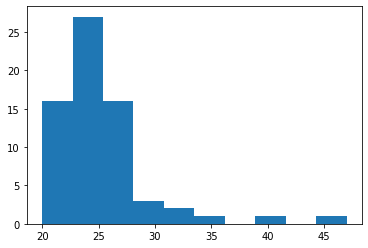

In [35]:
plt.hist(subject_df["Age"])
print("Mean:", np.mean(subject_df["Age"]))
print("Max:", np.max(subject_df["Age"]))
print("Min:", np.min(subject_df["Age"]))

In [31]:
np.mean(subject_df["Gender"] == "M")

0.7164179104477612

FOL


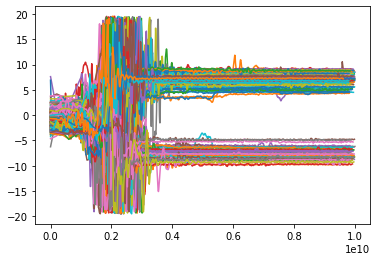

FKL


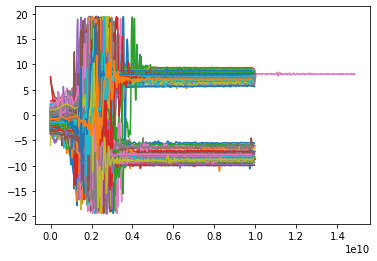

BSC


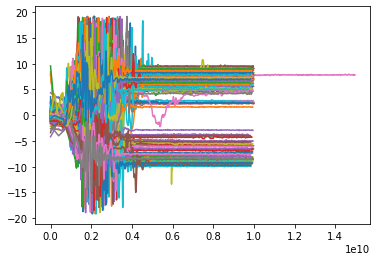

SDL


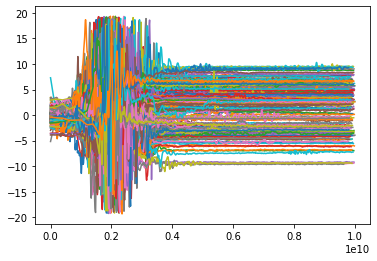

In [22]:
for fall_type in fall_types:
    print(fall_type)
    for key in all_data[fall_type]:
        data = all_data[fall_type][key]
        elapsed = [r[0] - data[0][0] for r in data]
        zacc = [r[3] for r in data]
        plt.plot(elapsed, zacc)
    plt.show()
    plt.close()

STD


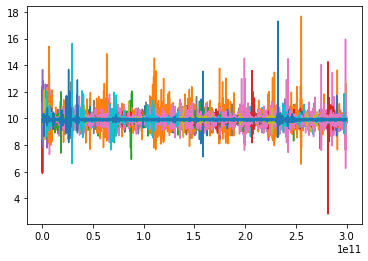

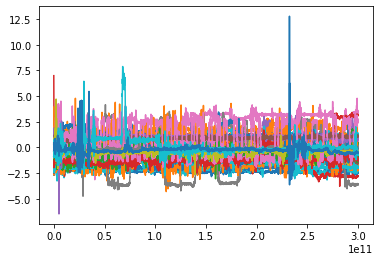

WAL


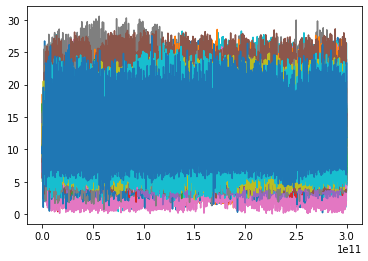

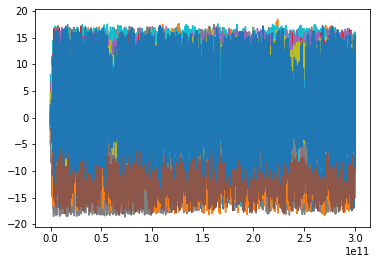

JOG


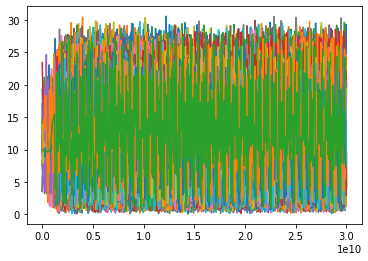

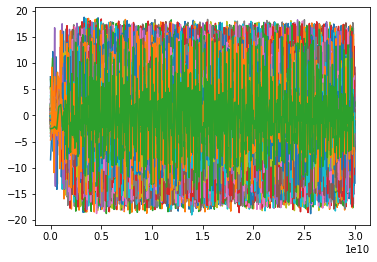

JUM


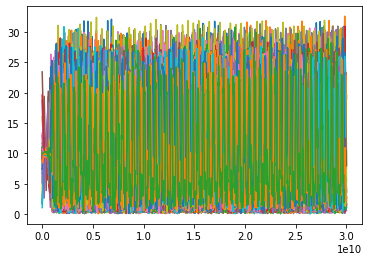

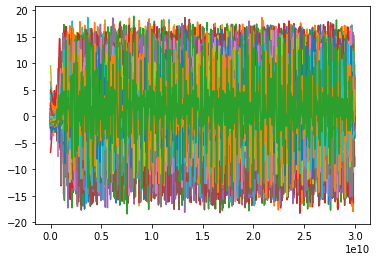

STU


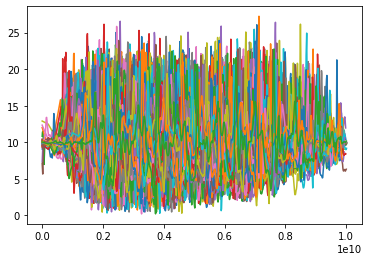

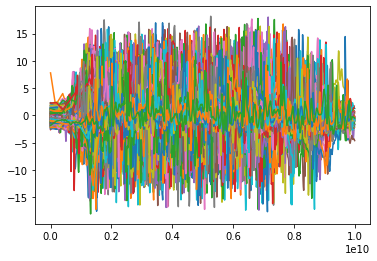

STN


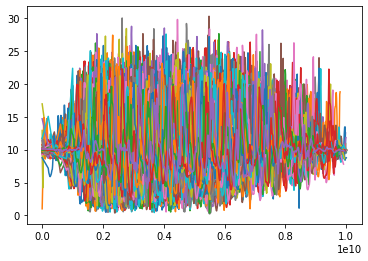

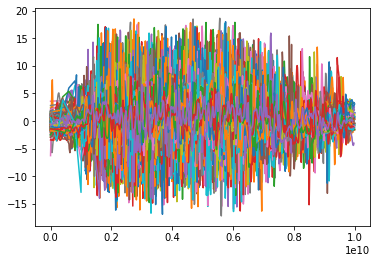

SCH


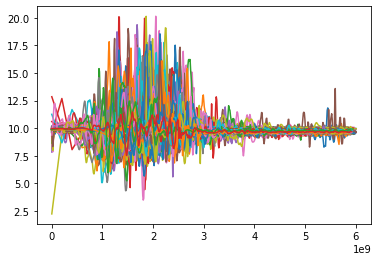

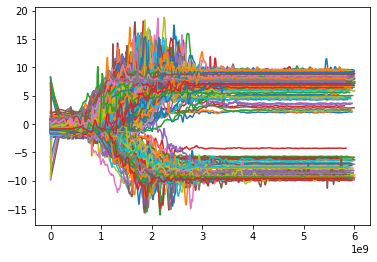

SIT


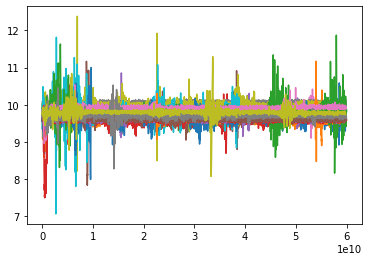

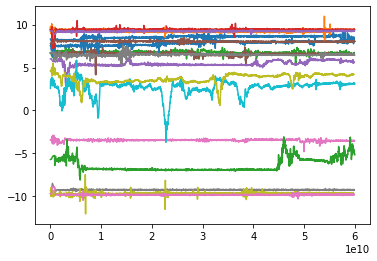

CHU


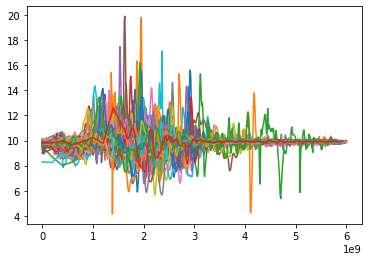

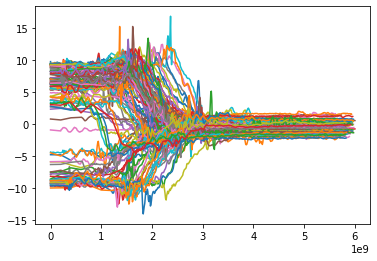

CSI


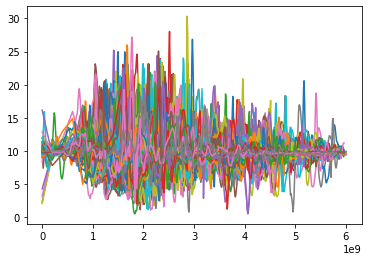

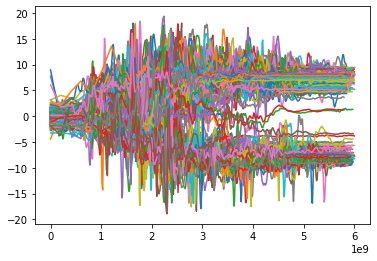

CSO


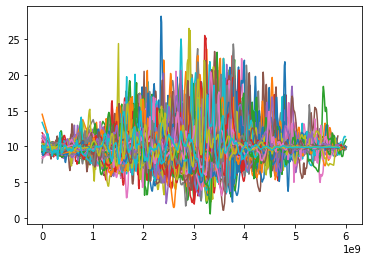

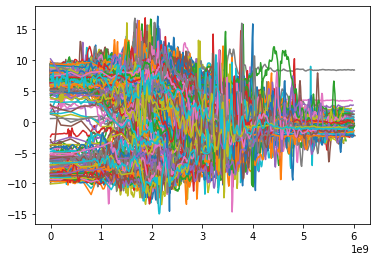

LYI
FALL FOL


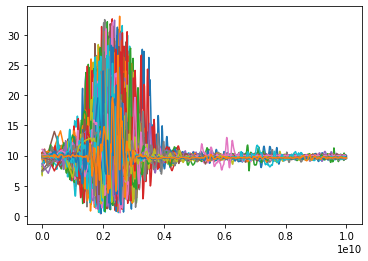

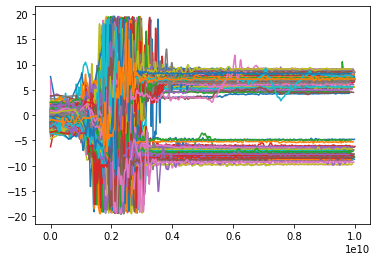

FALL FKL


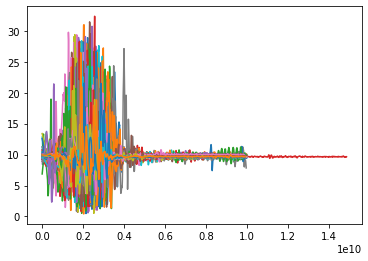

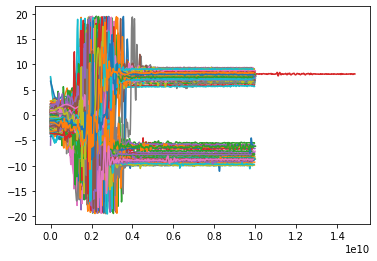

FALL BSC


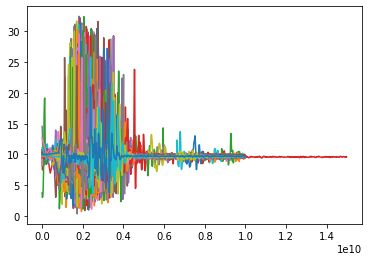

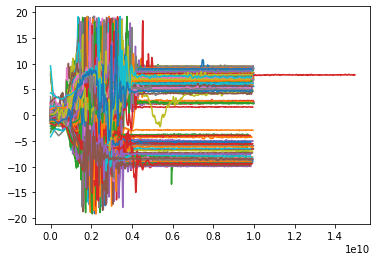

FALL SDL


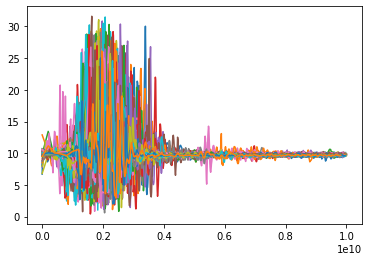

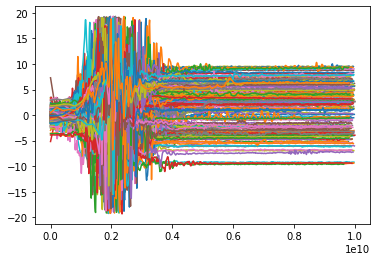

In [62]:
for typ in types:
    print(typ if typ not in fall_types else 'FALL ' + typ)
    type_data = data_df[data_df.type == typ]
    for (name, group) in type_data.groupby('trial'):
        plt.plot(group.elapsed, group.tot_acc)
    plt.show()
    plt.close()
    for (name, group) in type_data.groupby('trial'):
        plt.plot(group.elapsed, group.zacc)
    plt.show()
    plt.close()

## Feature Engineering & Model Building

In [33]:
# engineer some features
data_X = []
data_y = []
for (name, group) in tqdm.tqdm(data_df.groupby('id')):
    y = group.is_fall.iloc[0]
    max_tot = max(group.tot_acc)
    mean_tot_acc = np.mean(group.tot_acc)
    max_abs_zacc = max(abs(group.zacc))
    # now get duration of time above a z-acceleration of 15
    elapsed_above = group.elapsed[abs(group.zacc) > 15]
    if len(elapsed_above) < 2:
        duration_cap_15 = 0
    else:
        duration_cap_15 = elapsed_above.iloc[-1] - elapsed_above.iloc[0]
    # now get difference in absolute z-acceleration from start to finish
    start_z_acc = group.zacc.iloc[0]
    end_z_acc = group.zacc.iloc[-1]
    z_diff = abs(end_z_acc - start_z_acc)
    X = [max_tot, mean_tot_acc, max_abs_zacc, duration_cap_15, z_diff]
    data_X += [X]
    data_y += [y]
data_X = np.array(data_X)
data_y = np.array(data_y)

100%|██████████| 3198/3198 [00:03<00:00, 1012.16it/s]


In [34]:
print(len(data_X))
print(len(data_y))

3198
3198


In [35]:
# Get ratio of positive to negative examples
sum(data_y == True)/len(data_y)

0.23983739837398374

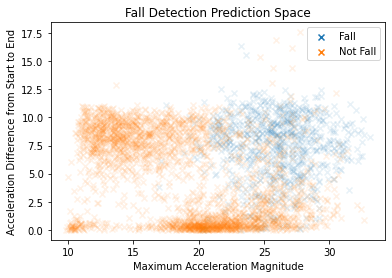

In [37]:
DIM_X = 0
DIM_Y = 4
plt.scatter([i[DIM_X] for i in data_X[np.array(data_y) == True]], [i[DIM_Y] for i in data_X[np.array(data_y) == True]],
            marker="x", label='Fall', alpha=0.1)
plt.title('Fall Detection Prediction Space')
plt.xlabel('Maximum Acceleration Magnitude')
plt.ylabel('Acceleration Difference from Start to End')
plt.scatter([i[DIM_X] for i in data_X[np.array(data_y) == False]], [i[DIM_Y] for i in data_X[np.array(data_y) == False]],
            marker="x", label='Not Fall', alpha=0.1)
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)

In [38]:
# do train/test split
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2)

In [39]:
# fit a model
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X_train, y_train)

In [40]:
# now look at performance
def performance(confusion):
    TN, FP, FN, TP = confusion.ravel()
    ACC_rate = (TP + TN)/(FP + FN + TP + TN)
    FP_rate = FP/(FP + TN)
    FN_rate = FN/(FN + TP)
    return (ACC_rate, FP_rate, FN_rate)
pred_y = clf.predict(X_test)
confusion = confusion_matrix(y_test, pred_y)
perf = performance(confusion)
perf_df = pd.DataFrame(perf, columns=['Decision Tree'])
perf_df.index = ['Accuracy', 'False Positive Rate', 'False Negative Rate']
perf_df = perf_df*100 # change to percentage
perf_df

,Decision Tree
Accuracy,91.718750
False Positive Rate,7.231405
False Negative Rate,11.538462


In [152]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                     feature_names=['Max Acc.', 'Mean Acc.', 'Max Z-Acc.'],  
                     class_names=['Not Fall', 'Fall'],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
#graph 

ValueError: Length of feature_names, 3 does not match number of features, 2

(6.604179725517441, 15.384179725517253, -0.2530091, 20.52699089999999)

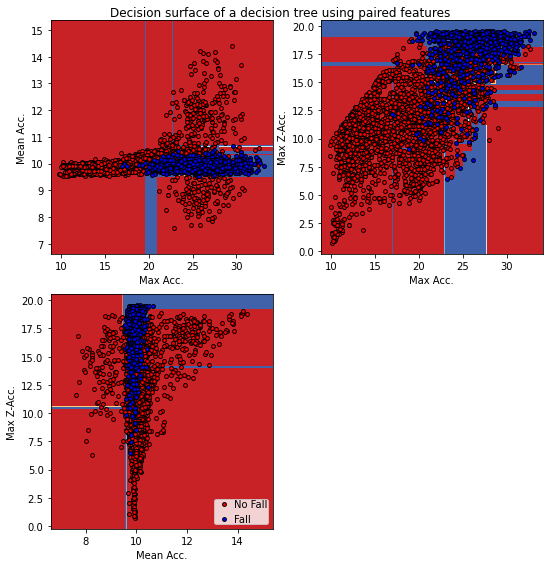

In [41]:

# Parameters
n_classes = 2
plot_colors = "rb"
plot_step = 0.02

feature_names = ['Max Acc.', 'Mean Acc.', 'Max Z-Acc.', 'High Acceleration Duration']
target_names = ['No Fall', 'Fall']

# Load data
plt.figure(figsize=(8,8))
n_attrs = 3
pairings = []
for i in range(n_attrs-1):
    for j in range(i+1, n_attrs):
        pairings.append([i, j])
for pairidx, pair in enumerate(pairings):
    # We only take the two corresponding features
    X = data_X[:, pair]
    y = data_y

    # Train
    clf = tree.DecisionTreeClassifier().fit(X, y)

    # Plot the decision boundary
    plt.subplot(2, int(n_attrs / 2) + n_attrs % 2, pairidx + 1)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(feature_names[pair[0]])
    plt.ylabel(feature_names[pair[1]])

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=target_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight")

In [115]:
clf.decision_path(X_test)

<640x453 sparse matrix of type '<class 'numpy.int64'>'
	with 5328 stored elements in Compressed Sparse Row format>

In [116]:
# cross validation
tree_model = tree.DecisionTreeClassifier()
cross_val_score(tree_model, data_X, data_y, cv=5, scoring='accuracy')

array([0.9015625 , 0.921875  , 0.6828125 , 0.86384977, 0.85758998])